In [1]:
import os
import h5py
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd
import copy

from joblib import Parallel, delayed
import multiprocessing

#result_list = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(self.matrix_element_core)(hn, theta_epsilon, phi_epsilon, k_x, k_y) for hn in hn_range)


# Bare band results from DFT calculation 

In [23]:
file_name = 'EuCd2As2_Aafmb_dZ_U5_SOC_scf2_kpdos.dat'
E_F = 2.41394570

#file_name = 'EuCd2P2_Aafmb_dZ_U5_SOC_scf2_kpdos.dat'
#E_F = 3.53706239

f = open(file_name, 'r')
content = f.readlines()

k_pts_num = int(content[1].split()[3])
band_num = int(content[1].split()[7])
ion_num = int(content[1].split()[11])

k_pts_list = []; energy_list = []
orbital_component_1 = []; orbital_component_2 = []; orbital_component_3 = []; orbital_component_4 = []

energy_list_temp = []
orbital_component_1_temp = []; orbital_component_2_temp = []
orbital_component_3_temp = []; orbital_component_4_temp = []

line_idx = 2
while line_idx <len(content):
    current_line = content[line_idx].split()
    
    # empty line
    if len(current_line) == 0:
        line_idx += 1
    
    # new k-point
    elif current_line[0] == 'k-point':
        if len(energy_list_temp) > 0:
            energy_list.append(energy_list_temp)
        if len(orbital_component_1_temp) > 0:
            orbital_component_1.append(orbital_component_1_temp)
            orbital_component_2.append(orbital_component_2_temp)
            orbital_component_3.append(orbital_component_3_temp)
            orbital_component_4.append(orbital_component_4_temp)
        k_pts_list.append([float(current_line[3]), float(current_line[4]), float(current_line[5])])
        energy_list_temp = []
        orbital_component_1_temp = []; orbital_component_2_temp = []
        orbital_component_3_temp = []; orbital_component_4_temp = []
        line_idx += 1
        
    # new band at current k-point
    elif current_line[0] == 'band':
        energy_list_temp.append(float(current_line[4])-E_F)
        line_idx += 1
        
    elif current_line[0] == 'ion':
        # load first block
        temp_ar = []
        for ion_idx in np.arange(1, ion_num+1, 1):
            temp_1 = [float(j) for j in content[line_idx+ion_idx].split()]
            temp_ar.append(temp_1[1:(len(temp_1)-1)])
        orbital_component_1_temp.append(np.array(temp_ar))
        
        # load second block
        line_idx += (ion_num + 2)
        temp_ar = []
        for ion_idx in np.arange(1, ion_num+1, 1):
            temp_1 = [float(j) for j in content[line_idx+ion_idx].split()]
            temp_ar.append(temp_1[1:(len(temp_1)-1)])
        orbital_component_2_temp.append(np.array(temp_ar))
        
        # load third block
        line_idx += (ion_num + 2)
        temp_ar = []
        for ion_idx in np.arange(1, ion_num+1, 1):
            temp_1 = [float(j) for j in content[line_idx+ion_idx].split()]
            temp_ar.append(temp_1[1:(len(temp_1)-1)])
        orbital_component_3_temp.append(np.array(temp_ar))
        
        # load fourth block
        line_idx += (ion_num + 2)
        temp_ar = []
        for ion_idx in np.arange(1, ion_num+1, 1):
            temp_1 = [float(j) for j in content[line_idx+ion_idx].split()]
            temp_ar.append(temp_1[1:(len(temp_1)-1)])
        orbital_component_4_temp.append(np.array(temp_ar))
        
        line_idx += (ion_num + 2)
        
    else:
        line_idx += 1
        
# laod last k-point
energy_list.append(energy_list_temp)
orbital_component_1.append(orbital_component_1_temp)
orbital_component_2.append(orbital_component_2_temp)
orbital_component_3.append(orbital_component_3_temp)
orbital_component_4.append(orbital_component_4_temp)

f.close()

k_pts_list = np.array(k_pts_list)
energy_list = np.array(energy_list)


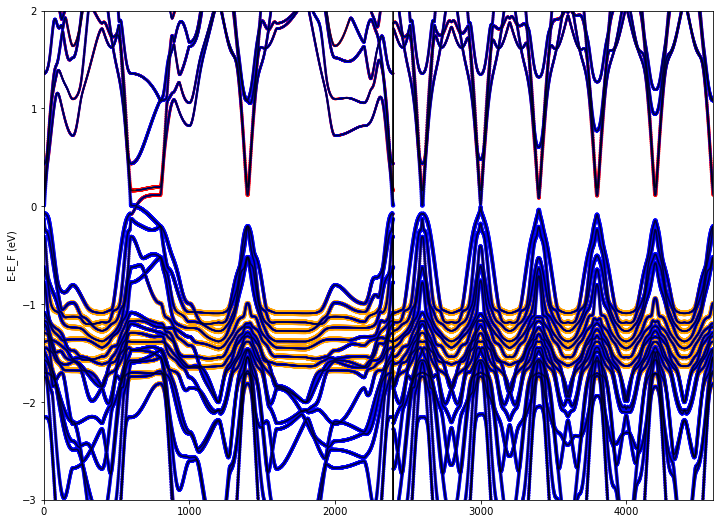

In [24]:
#k_list_plot = np.arange(0, 1400, 1)
k_list_plot = np.arange(0, k_pts_list.shape[0], 1)

# Uniform length of high symmetry path
k_path = k_list_plot

# EuCd2As2
'''
k_path = list(np.linspace(0, 1.643/2, 200))\
+list(np.linspace(1.643/2, 1.643/2+1.643/4, 200))\
+list(np.linspace(1.643/2+1.643/4, 1.643/2+1.643/4+0.9434, 200))\
+list(np.linspace(1.643/2+1.643/4+0.9434, 1.643/2+1.643/4+0.9434+0.8574/2, 200))\
+list(np.linspace(1.643/2+1.643/4+0.9434+0.8574/2, 1.643/2+1.643/4+0.9434+0.8574/2+1.643/2, 200))\
+list(np.linspace(1.643/2+1.643/4+0.9434+0.8574/2+1.643/2, 1.643/2+1.643/4+0.9434+0.8574/2+1.643/2+1.643/4, 200))\
+list(np.linspace(1.643/2+1.643/4+0.9434+0.8574/2+1.643/2+1.643/4, 1.643/2+1.643/4+0.9434+0.8574/2+1.643/2+1.643/4+0.9434, 200))
'''

# EuCd2P2

'''
k_path = list(np.linspace(0, 1.677/2, 200))\
+list(np.linspace(1.677/2, 1.677/2+1.677/4, 200))\
+list(np.linspace(1.677/2+1.677/4, 1.677/2+1.677/4+0.9682, 200))\
+list(np.linspace(1.677/2+1.677/4+0.9682, 1.677/2+1.677/4+0.9682+0.8752/2, 200))\
+list(np.linspace(1.677/2+1.677/4+0.9682+0.8752/2, 1.677/2+1.677/4+0.9682+0.8752/2+1.677/2, 200))\
+list(np.linspace(1.677/2+1.677/4+0.9682+0.8752/2+1.677/2, 1.677/2+1.677/4+0.9682+0.8752/2+1.677/2+1.677/4, 200))\
+list(np.linspace(1.677/2+1.677/4+0.9434+0.8752/2+1.677/2+1.677/4, 1.677/2+1.677/4+0.9434+0.8752/2+1.677/2+1.677/4+0.9682, 200))
'''


plt.figure(figsize=(12,9))
for band_idx in range(energy_list.shape[1]):
    plt.plot(k_path, energy_list[k_list_plot, band_idx], c = 'black', alpha=0.5)

cache = []
for j in k_list_plot:
    def func(k):
        orbital_component = orbital_component_1[j][k]
        #Eu_5d = np.sum(orbital_component[0:2, 4:9])
        Cd_5s = np.sum(orbital_component[2:6, 0])
        Eu_4f = np.sum(orbital_component[0:2, 9:16])
        As_4p = np.sum(orbital_component[6:10, 1:4])
        return [k_path[j], energy_list[j,k], [Cd_5s, Eu_4f, As_4p]]
    
    cache.extend([func(k) for k in range(energy_list.shape[1])])
    
dot_size_ratio = 20
plt.scatter([cache[j][0] for j in range(len(cache))], [cache[j][1] for j in range(len(cache))], \
            s=[dot_size_ratio*cache[j][2][0] for j in range(len(cache))], c='red', alpha=.5, label='Cd 5s')
plt.scatter([cache[j][0] for j in range(len(cache))], [cache[j][1] for j in range(len(cache))], \
            s=[dot_size_ratio*cache[j][2][1] for j in range(len(cache))], c='orange', alpha=.5, label='Eu 4f')
plt.scatter([cache[j][0] for j in range(len(cache))], [cache[j][1] for j in range(len(cache))], \
            s=[dot_size_ratio*cache[j][2][2] for j in range(len(cache))], c='blue', alpha=.5, label='As 4p')

#plt.grid(which='both' ,axis = 'x')
#plt.hlines(0, 0, len(k_list_plot), color='black', linestyle = '--', alpha=.5)
plt.ylabel('E-E_F (eV)')
plt.ylim(-3, 2)
plt.xlim(k_path[0], k_path[-1])
#plt.legend()
plt.savefig(''.join([file_name[0:(len(file_name)-4)], '.pdf']), dpi=100)
plt.savefig(''.join([file_name[0:(len(file_name)-4)], '.png']), dpi=100)



Text(0.5, 0, 'z')

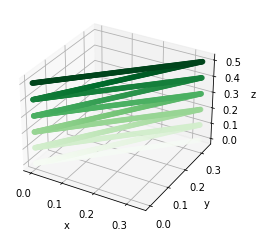

In [25]:
ax = plt.axes(projection='3d')

temp = 4600
xdata = k_pts_list[2400:temp,0]; ydata = k_pts_list[2400:temp,1]; zdata = k_pts_list[2400:temp,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap="Greens");
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


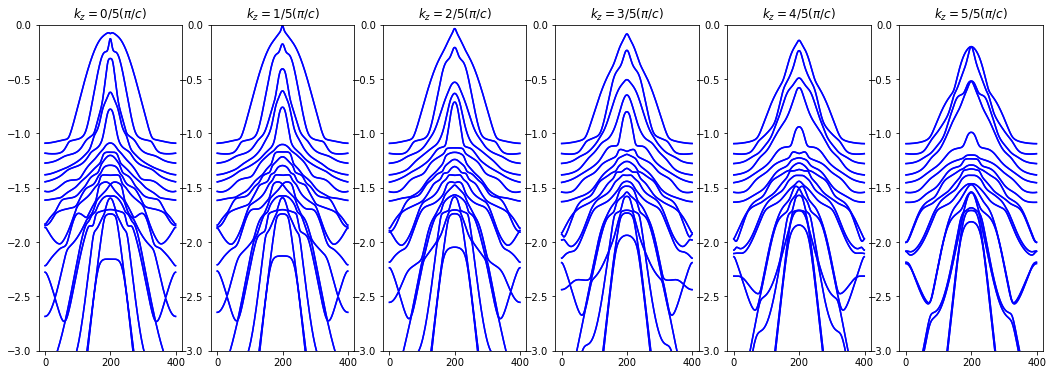

In [26]:
def mirror_spectra(spectra, axis = 'right'):
    if axis == 'right':
        return np.concatenate((spectra, np.flip(spectra, 0)), axis=0)

dft_band = [mirror_spectra(energy_list[2400:2600,:]), mirror_spectra(energy_list[2800:3000,:]),\
            mirror_spectra(energy_list[3200:3400,:]),mirror_spectra(energy_list[3600:3800,:]),\
            mirror_spectra(energy_list[4000:4200,:]), mirror_spectra(energy_list[4400:4600,:])]

plt.figure(figsize=(18,6))

for idx in range(6):
    plt.subplot(1,6,idx+1)
    for band_idx in range(dft_band[idx].shape[1]):
        plt.plot(dft_band[idx][:, band_idx], c='b')

    plt.ylim(-3,0)
    plt.title(''.join(['$k_z=$', str(idx), '$/5(\pi/c)$']))


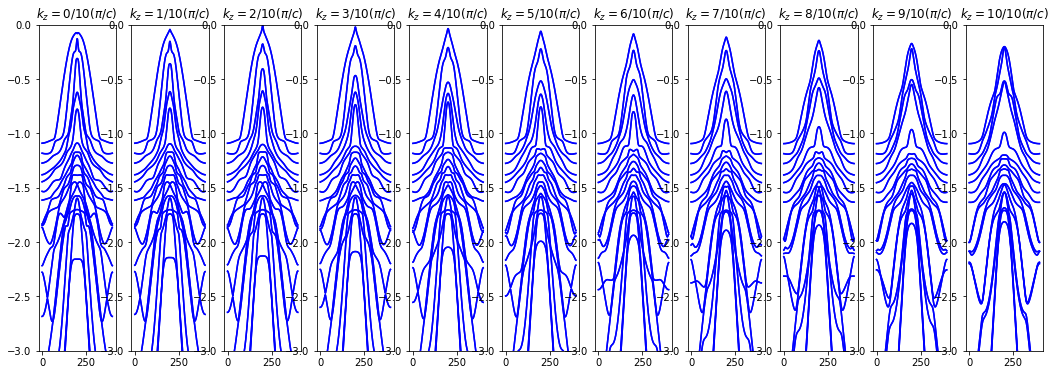

In [27]:
# row - k; col - e
dft_band_full = [dft_band[0], np.add(dft_band[0], dft_band[1])/2,\
                dft_band[1], np.add(dft_band[1], dft_band[2])/2,\
                dft_band[2], np.add(dft_band[2], dft_band[3])/2,\
                dft_band[3], np.add(dft_band[3], dft_band[4])/2,\
                dft_band[4], np.add(dft_band[4], dft_band[5])/2, dft_band[5]]

plt.figure(figsize=(18,6))

for idx in range(11):
    plt.subplot(1,11,idx+1)
    for band_idx in range(dft_band_full[idx].shape[1]):
        plt.plot(dft_band_full[idx][:, band_idx], c='b')

    plt.ylim(-3,0)
    plt.title(''.join(['$k_z=$', str(idx), '$/10(\pi/c)$']))


# Experimental data

In [28]:
ECA_80eV = pd.read_csv('ECA_80eV_spectra.csv', header=None).to_numpy()[0:429, 0:1000]
ECA_k_axis = np.linspace(-0.945926453898404, 0.942115406516874, 429)
ECA_e_axis = np.linspace(-1.0017, -0.00270000000000259, 1000)

ECP_80eV = pd.read_csv('ECP_80eV_spectra.csv', header=None).to_numpy()[0:618, 0:402]
ECP_k_axis = np.linspace(-0.967925390474959, 0.969515877833538, 618)
ECP_e_axis = np.linspace(-0.802699999999995, -0.000699999999999257, 402)

exp_spectra = ECA_80eV; exp_k_axis = ECA_k_axis; exp_e_axis = ECA_e_axis
#exp_spectra = ECP_80eV; exp_k_axis = ECP_k_axis; exp_e_axis = ECP_e_axis



# Spectra simulation

In [29]:
class spectra_kz_simulation:
    def __init__(self, config):
        self.dft_bands_list = config['DFT bands']
        self.hn = config['hn']-4.35
        self.self_energy_r = config['self energy real']
        self.self_energy_im = config['self energy img']
        self.pi_over_c = np.pi/config['c']
        self.sim_omega_axis = config['simulation e axis']
        self.sim_k_axis = config['simulation k axis']

        def eV2J(eV):
            return 1.60218e-19*eV
        def J2eV(J):
            return J/1.60218e-19

        e_mass = 9.1093837e-31; h_bar = 1.054571817e-34
        self.k_0 = np.sqrt(2*e_mass*eV2J(self.hn))/h_bar
        self.v_perp = np.power(h_bar,2)*self.k_0/e_mass
        self.sigma = eV2J(self.self_energy_im)/self.v_perp
        
    def A_i(self, kz_idx):
        band = self.dft_bands_list[kz_idx]
        spectra = np.zeros((band.shape[0], len(self.sim_omega_axis)))
        for j in range(spectra.shape[0]):
            for k in range(band.shape[1]):
                epsilon_k = band[j,k]
                for l in range(spectra.shape[1]):
                    omega = self.sim_omega_axis[l]
                    spectra[j,l] += self.self_energy_im/(np.power(omega-epsilon_k-self.self_energy_r,2) + np.power(self.self_energy_im,2))
        
        spectra /= np.sum(spectra)
        
        return spectra
    
    def A_kz_int(self):
        #sim_spectra = [A_i(j) for j in range(len(dft_band_full))]
        sim_spectra = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(self.A_i)(j) for j in range(len(self.dft_bands_list)))
        k_perp_idx_seed = list(np.arange(0, len(self.dft_bands_list), 1))+list(np.arange(len(self.dft_bands_list)-2, 0, -1))
        k_absolute_value_seed = self.pi_over_c*np.arange(0,len(k_perp_idx_seed),1)/(len(self.dft_bands_list)-1)
        self.k_perp_idx = []
        self.k_absolute_value = []

        for j in np.arange(1,500,1):
            self.k_perp_idx.extend(k_perp_idx_seed)
            self.k_absolute_value.extend(list(2*j*self.pi_over_c+k_absolute_value_seed))
        
        sim_spectra_kz_int = np.zeros(sim_spectra[0].shape)
        self.kz_weight = []
        for j in range(len(self.k_perp_idx)):
            self.kz_weight.append(self.sigma/(np.power(self.k_absolute_value[j]-self.k_0,2)+np.power(self.sigma,2)))
            sim_spectra_kz_int += self.kz_weight[-1]*sim_spectra[self.k_perp_idx[j]]
        
        sim_spectra_norm = sim_spectra_kz_int/np.sum(sim_spectra_kz_int)
        #plt.imshow(np.log(sim_spectra_norm).T)
        
        return sim_spectra_norm

    def analysis_plot(self):
        #plt.figure(1)
        #plt.scatter(range(len(self.k_absolute_value)), self.k_absolute_value)
        #plt.hlines(self.k_0, 0, len(self.k_absolute_value), color='red', linestyle='--', label='$k_0$')
        #plt.hlines(1.60218e-19*self.self_energy_im/self.v_perp, 0, len(self.k_absolute_value),  color='green', linestyles='--', label='$\sigma$')
        #plt.yscale('log')
        #plt.legend()
        #plt.ylabel('$k_\perp$ (1/m)')
        
        #plt.figure(2)
        plt.plot(np.array(self.k_perp_idx)/10, self.kz_weight)
        plt.title('kz_weight')
        plt.xlabel('$\pi/c$')
        plt.ylabel('kz weight')


In [32]:
sim_e_axis = list(np.linspace(-3, 0, 600));
sim_k_axis = list(np.linspace(-0.9434, 0.9434, dft_band_full[0].shape[0]))
#sim_k_axis = list(np.linspace(-0.9682, 0.9682, dft_band_full[0].shape[0]))

config = {
    "DFT bands": dft_band_full,
    "hn": 80,
    "self energy real": 0,
    "self energy img": 1.5e-1,
    "c": 4.28e-9, # ECA: 4.28e-9; ECP: 3.589e-9
    "simulation e axis": sim_e_axis,
    "simulation k axis": sim_k_axis
}

temp = spectra_kz_simulation(config)
sim_spectra = temp.A_i(0)

np.savetxt("kz_simulation_temp.csv", sim_spectra, delimiter=',')
print(sim_spectra.shape)


(400, 600)


(0.0, 600.0)

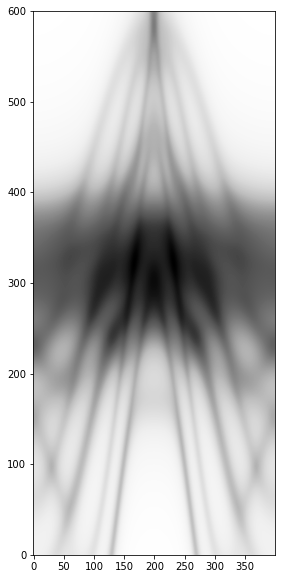

In [33]:
plt.figure(figsize=(5,10))
plt.imshow(sim_spectra.T, cmap='Greys', aspect=1.5)
plt.ylim(0, sim_spectra.shape[1])

In [ ]:
temp.analysis_plot()

In [ ]:
sim_spectra = temp.A_kz_int()

In [ ]:
temp.analysis_plot()

In [ ]:
sim_e_axis = list(np.linspace(-1, 0, 500));
#sim_k_axis = list(np.linspace(-0.9434, 0.9434, dft_band_full[0].shape[0]))
sim_k_axis = list(np.linspace(-0.9682, 0.9682, dft_band_full[0].shape[0]))

def mse(sim_spectra, exp_spectra, sim_k_axis, sim_e_axis, exp_k_axis, exp_e_axis):
    loss = 0
    sim_spectra /= np.sum(sim_spectra)
    exp_spectra /= np.sum(exp_spectra)
    for j in range(exp_spectra.shape[0]):
        j_idx = np.argmin([np.abs(exp_k_axis[j]-sim_k_axis[l]) for l in range(len(sim_k_axis))])
        for k in range(exp_spectra.shape[1]):
            k_idx = np.argmin([np.abs(exp_e_axis[k]-sim_e_axis[l]) for l in range(len(sim_e_axis))])
            loss += exp_spectra[j,k] - sim_spectra[j_idx, k_idx]
    
    return loss
    
def fit(exp_spectra, sim_self_energy_im_range, sim_e_axis, exp_k_axis, exp_e_axis):
    loss_hist = []
    for self_energy_im in sim_self_energy_im_range:
        print(self_energy_im)
        config = {
        "DFT bands": dft_band_full,
        "hn": 80,
        "self energy real": 0,
        "self energy img": self_energy_im,
        "c": 4.28e-9, # ECA: 4.28e-9; ECP: 3.589e-9
        "simulation e axis": sim_e_axis,
        "simulation k axis": sim_k_axis
        }
        sim_spectra = spectra_kz_simulation(config).A_kz_int()
        loss_hist.append(mse(sim_spectra, exp_spectra, sim_k_axis, sim_e_axis, exp_k_axis, exp_e_axis))
        
    plt.plot(sim_self_energy_im_range, loss_hist)
    return loss_hist, sim_self_energy_im_range[np.argmin(loss_hist)]
        

sim_self_energy_im_range = np.arange(0,1,0.05)
sim_self_energy_im_range_all = [list(sim_self_energy_im_range)]
loss_hist, self_energy_opt = fit(exp_spectra, sim_self_energy_im_range, sim_e_axis, exp_k_axis, exp_e_axis)
sim_self_energy_im_range_all = [list(sim_self_energy_im_range)]


In [ ]:
#loss_hist, self_energy_opt = fit(exp_spectra, sim_self_energy_im_range, sim_e_axis, exp_k_axis, exp_e_axis)
#loss_hist_all = copy.deepcopy(loss_hist)
#sim_e_axis = list(np.linspace(-1, 0, 500));
#sim_k_axis = list(np.linspace(-0.9434, 0.9434, dft_band_full[0].shape[0]))